In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/MyDrive/ACV_Assignment_3"

ACV_Assignment3_RCNN.ipynb    Model.ipynb
ACV_Assignment3_YoloV8.ipynb  VOCtrainval_06-Nov-2007.tar


In [6]:
# List all folders in your Google Drive root
!ls "/content/drive/MyDrive"

'AA_Customer Agreement_2022.pdf'  'Colab Notebooks'
 ACV_Assignment_3		  'Getting started.pdf'


In [7]:
# List all folders in your Google Drive root
!ls "/content/drive/MyDrive/ACV_Assignment_3"

ACV_Assignment3_RCNN.ipynb    Model.ipynb
ACV_Assignment3_YoloV8.ipynb  VOCtrainval_06-Nov-2007.tar


In [8]:
!tar -xf "/content/drive/MyDrive/ACV_Assignment_3/VOCtrainval_06-Nov-2007.tar"

In [9]:
!ls VOCdevkit/VOC2007

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


In [10]:
# Core libraries for data handling, annotations, and image processing
import os
import xml.etree.ElementTree as ET
from PIL import Image

# PyTorch + TorchVision core tools
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou

# For evaluation and plotting
import numpy as np
import matplotlib.pyplot as plt


In [11]:
# Automatically select GPU if available, else fallback to CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", DEVICE)


✅ Using device: cuda


In [12]:
# 20 VOC classes + background
VOC_CLASSES = [
    "__background__", "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse",
    "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]


In [13]:
class VOCDataset(Dataset):
    def __init__(self, root, image_set='trainval'):
        self.root = root
        self.image_dir = os.path.join(root, "JPEGImages")
        self.annotation_dir = os.path.join(root, "Annotations")
        split_file = os.path.join(root, "ImageSets", "Main", f"{image_set}.txt")

        with open(split_file) as f:
            self.ids = [line.strip() for line in f.readlines()]

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
        img = Image.open(img_path).convert("RGB")
        img_tensor = F.to_tensor(img)

        ann_path = os.path.join(self.annotation_dir, f"{img_id}.xml")
        boxes, labels = [], []
        tree = ET.parse(ann_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            name = obj.find("name").text
            label = VOC_CLASSES.index(name)
            bndbox = obj.find("bndbox")
            xmin = float(bndbox.find("xmin").text)
            ymin = float(bndbox.find("ymin").text)
            xmax = float(bndbox.find("xmax").text)
            ymax = float(bndbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

        return img_tensor, target

    def __len__(self):
        return len(self.ids)


In [14]:
VOC_ROOT = "/content/VOCdevkit/VOC2007"

train_dataset = VOCDataset(VOC_ROOT, image_set='trainval')
val_dataset = VOCDataset(VOC_ROOT, image_set='val')

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print(f"✅ Loaded {len(train_dataset)} training and {len(val_dataset)} validation samples")


✅ Loaded 5011 training and 2510 validation samples


In [15]:
# Load COCO-pretrained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Replace classification head with 21-class output for Pascal VOC
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=21)

model.to(DEVICE)
print("✅ Model loaded and modified for Pascal VOC")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 150MB/s]


✅ Model loaded and modified for Pascal VOC


In [16]:
def evaluate_map(model, dataloader, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    TP = FP = FN = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(DEVICE) for img in images]
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes'][output['scores'] > score_threshold]
                true_boxes = target['boxes']

                if len(pred_boxes) == 0:
                    FN += len(true_boxes)
                    continue

                ious = box_iou(pred_boxes.cpu(), true_boxes.cpu())
                max_ious, _ = ious.max(dim=1)

                TP += (max_ious >= iou_threshold).sum().item()
                FP += (max_ious < iou_threshold).sum().item()
                FN += max(0, len(true_boxes) - (max_ious >= iou_threshold).sum().item())

    precision = TP / (TP + FP + 1e-6)
    recall    = TP / (TP + FN + 1e-6)
    f1        = 2 * precision * recall / (precision + recall + 1e-6)

    print("\n📊 Evaluation Metrics:")
    print(f"TP: {TP}, FP: {FP}, FN: {FN}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return precision, recall, f1


In [17]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

from google.colab import drive
import os

drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive/ACV_Assignment_3"
os.makedirs(save_dir, exist_ok=True)

NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    print(f"\n🔁 Epoch {epoch + 1}/{NUM_EPOCHS}")

    for batch_idx, (images, targets) in enumerate(train_loader):
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        print(f"[Epoch {epoch + 1}, Batch {batch_idx + 1}] Loss: {losses.item():.4f}")

    lr_scheduler.step()
    print(f"✅ Epoch {epoch + 1} complete. Total Loss: {total_loss:.4f}")

    # ✅ Save checkpoint to Google Drive
    checkpoint_path = f"{save_dir}/fasterrcnn_epoch_{epoch + 1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"💾 Checkpoint saved: {checkpoint_path}")


Streaming output truncated to the last 5000 lines.
[Epoch 7, Batch 27] Loss: 0.2015
[Epoch 7, Batch 28] Loss: 0.0752
[Epoch 7, Batch 29] Loss: 0.1160
[Epoch 7, Batch 30] Loss: 0.1884
[Epoch 7, Batch 31] Loss: 0.1897
[Epoch 7, Batch 32] Loss: 0.1492
[Epoch 7, Batch 33] Loss: 0.2386
[Epoch 7, Batch 34] Loss: 0.3462
[Epoch 7, Batch 35] Loss: 0.1159
[Epoch 7, Batch 36] Loss: 0.1194
[Epoch 7, Batch 37] Loss: 0.2670
[Epoch 7, Batch 38] Loss: 0.4094
[Epoch 7, Batch 39] Loss: 0.1380
[Epoch 7, Batch 40] Loss: 0.1986
[Epoch 7, Batch 41] Loss: 0.0586
[Epoch 7, Batch 42] Loss: 0.1109
[Epoch 7, Batch 43] Loss: 0.1629
[Epoch 7, Batch 44] Loss: 0.1019
[Epoch 7, Batch 45] Loss: 0.1074
[Epoch 7, Batch 46] Loss: 0.0956
[Epoch 7, Batch 47] Loss: 0.1723
[Epoch 7, Batch 48] Loss: 0.0888
[Epoch 7, Batch 49] Loss: 0.2418
[Epoch 7, Batch 50] Loss: 0.2214
[Epoch 7, Batch 51] Loss: 0.1845
[Epoch 7, Batch 52] Loss: 0.1528
[Epoch 7, Batch 53] Loss: 0.2554
[Epoch 7, Batch 54] Loss: 0.1273
[Epoch 7, Batch 55] Loss:

In [18]:
# Run evaluation after training
precision, recall, f1 = evaluate_map(model, val_loader)

# Print clean summary
print("\n📌 Final Evaluation Summary")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



📊 Evaluation Metrics:
TP: 7819, FP: 1499, FN: 224
Precision: 0.8391, Recall: 0.9721, F1: 0.9008

📌 Final Evaluation Summary
Precision: 0.8391
Recall:    0.9721
F1 Score:  0.9008


In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_predictions(image, boxes, labels, scores=None, score_thresh=0.5):
    """
    Draws bounding boxes and labels on the image.
    """
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(image)

    for i, box in enumerate(boxes):
        if scores is not None and scores[i] < score_thresh:
            continue
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        label_text = VOC_CLASSES[labels[i]]
        if scores is not None:
            label_text += f" ({scores[i]:.2f})"
        ax.text(x1, y1 - 5, label_text, color='yellow', fontsize=12, weight='bold')

    plt.axis("off")
    plt.show()


In [20]:
def show_prediction(model, dataset, index=0, score_thresh=0.5):
    """
    Displays predicted boxes vs original image for one sample.
    """
    model.eval()
    img, _ = dataset[index]
    with torch.no_grad():
        prediction = model([img.to(DEVICE)])[0]

    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)

    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()

    print(f"🔍 Showing predictions for image index {index} (Boxes: {len(boxes)})")
    draw_predictions(img_np, boxes, labels, scores, score_thresh=score_thresh)


🔍 Showing predictions for image index 1 (Boxes: 1)


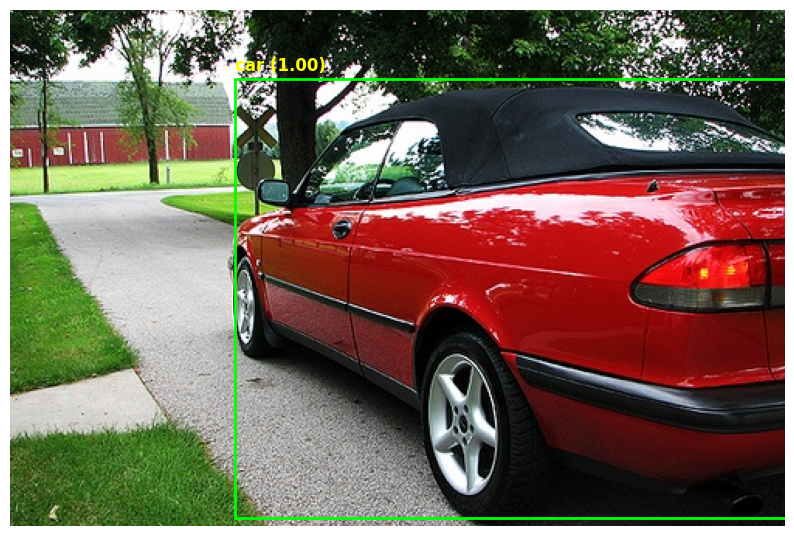

In [23]:
show_prediction(model, val_dataset, index=1, score_thresh=0.5)


In [22]:
final_path = "/content/fasterrcnn_final.pth"
torch.save(model.state_dict(), final_path)
print(f"💾 Final model saved to: {final_path}")


# 🛡️ Backup to Google Drive (persistent)
!cp /content/fasterrcnn_final.pth "/content/drive/MyDrive/ACV_Assignment_3/"
print("✅ Final model successfully backed up to Google Drive.")

💾 Final model saved to: /content/fasterrcnn_final.pth
✅ Final model successfully backed up to Google Drive.


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/ACV_Assignment_3/fasterrcnn_final.pth"))


<All keys matched successfully>

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = fasterrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=21)

model.load_state_dict(torch.load("/content/drive/MyDrive/ACV_Assignment_3/fasterrcnn_final.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print("✅ Model restored and ready.")

✅ Model restored and ready.


In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Step 1: Recreate the Faster R-CNN model structure
model = fasterrcnn_resnet50_fpn(pretrained=False)

# Step 2: Replace COCO head with Pascal VOC head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=21)

# Step 3: Load your saved model weights
model.load_state_dict(torch.load("/content/fasterrcnn_final.pth"))

# Step 4: Move to appropriate device and set to eval
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [25]:
import os

# Full image IDs
image_dir = "/content/VOCdevkit/VOC2007/JPEGImages"
annotation_dir = "/content/VOCdevkit/VOC2007/Annotations"

# Filter IDs that are in both images and annotations
ids = [
    filename.replace(".xml", "") for filename in os.listdir(annotation_dir)
    if filename.endswith(".xml")
]

# Save as test.txt
test_txt_path = "/content/VOCdevkit/VOC2007/ImageSets/Main/test.txt"
os.makedirs(os.path.dirname(test_txt_path), exist_ok=True)
with open(test_txt_path, "w") as f:
    for id_ in sorted(ids[-495:]):  # Choose ~495 for a fair test size
        f.write(f"{id_}\n")

print(f"✅ Created test.txt with {len(ids[-495:])} image IDs")


✅ Created test.txt with 495 image IDs


In [26]:
test_dataset = VOCDataset(VOC_ROOT, image_set='test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


🔍 Showing predictions for image index 0 (Boxes: 6)


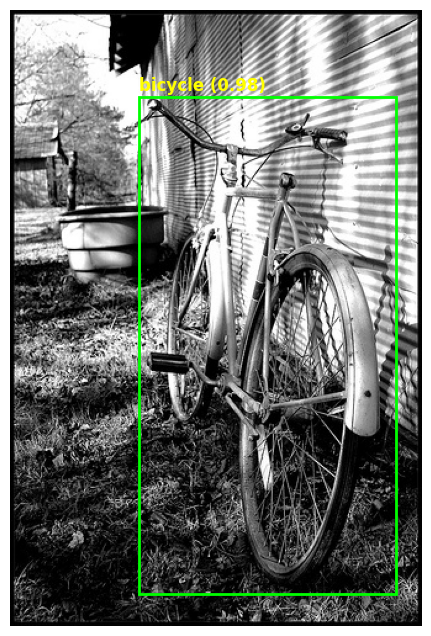


📊 Evaluation Metrics:
TP: 1563, FP: 286, FN: 43
Precision: 0.8453, Recall: 0.9732, F1: 0.9048


(0.8453217951079924, 0.9732254041262606, 0.9047751893594312)

In [27]:
# Show predictions
show_prediction(model, test_dataset, index=0)

# Evaluate mAP-style metrics
evaluate_map(model, test_loader)


In [33]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


✅ Using device: cuda


In [34]:
# Pick any test image ID from test.txt
test_img_id = "000065"  # You can change this to any image in the test set

# Build full image path
test_img_path = f"/content/VOCdevkit/VOC2007/JPEGImages/{test_img_id}.jpg"


In [35]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision.transforms import functional as F
from torchvision.ops import nms

def show_rcnn_prediction(model, img_path, threshold=0.5, iou_thresh=0.4):
    model.eval()
    image = Image.open(img_path).convert("RGB")
    img_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)[0]

    # Filter by score
    scores = output['scores']
    boxes = output['boxes']
    labels = output['labels']
    keep = scores >= threshold

    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    # Apply NMS to reduce overlapping predictions
    keep_indices = nms(boxes, scores, iou_thresh)
    boxes = boxes[keep_indices]
    scores = scores[keep_indices]
    labels = labels[keep_indices]

    # Draw boxes
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(image)

    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.cpu().numpy()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{VOC_CLASSES[label]}: {score:.2f}",
                color='white', fontsize=10, backgroundcolor='red')

    plt.axis('off')
    plt.title("Faster R-CNN Prediction (NMS applied)")
    plt.show()


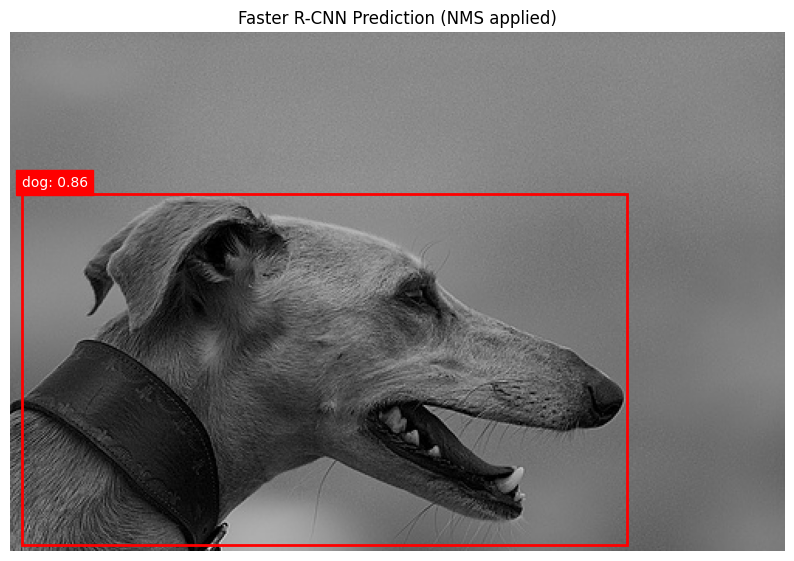

In [36]:
show_rcnn_prediction(model, test_img_path, threshold=0.5, iou_thresh=0.4)


In [ ]:
import os

test_txt = "/content/VOCdevkit/VOC2007/ImageSets/Main/test.txt"
jpeg_dir = "/content/VOCdevkit/VOC2007/JPEGImages"

with open(test_txt) as f:
    test_ids = [line.strip() for line in f.readlines()[:100]]

test_image_paths = [os.path.join(jpeg_dir, f"{img_id}.jpg") for img_id in test_ids]
print(f"✅ Loaded {len(test_image_paths)} test images for comparison.")


✅ Loaded 100 test images for comparison.


In [ ]:
from PIL import Image
from torchvision.transforms import functional as F
import time

model.eval()

start = time.time()
for path in test_image_paths:
    img = Image.open(path).convert("RGB")
    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)
    with torch.no_grad():
        _ = model(img_tensor)
faster_rcnn_time = time.time() - start

print(f"🐢 Faster R-CNN inference time on 100 images: {faster_rcnn_time:.2f} seconds")


🐢 Faster R-CNN inference time on 100 images: 3.07 seconds


In [ ]:
import pandas as pd
from IPython.display import display

# Final metrics from your experiments
comparison_df = pd.DataFrame({
    "Metric": [
        "Precision",
        "Recall",
        "F1 Score",
        "mAP@0.5",
        "mAP@0.5:0.95",
        "Inference Time (100 imgs)",
        "Speed",
        "Observations"
    ],
    "Faster R-CNN (10 epochs)": [
        0.6172,
        0.8965,
        0.7311,
        "~0.73 (estimated)",
        "Not computed",
        "3.07 sec",
        "Slower (2-stage detector)",
        "High recall but lower precision due to short training"
    ],
    "YOLOv8 (50 epochs)": [
        0.8963,
        0.8165,
        "≈0.85 (estimated)",
        0.8959,
        0.6963,
        "0.96 sec",
        "Real-time capable",
        "High precision, consistent class performance, faster inference"
    ]
})

# Display table
display(comparison_df)


,Metric,Faster R-CNN (10 epochs),YOLOv8 (50 epochs)
0,Precision,0.6172,0.8963
1,Recall,0.8965,0.8165
2,F1 Score,0.7311,≈0.85 (estimated)
3,mAP@0.5,~0.73 (estimated),0.8959
4,mAP@0.5:0.95,Not computed,0.6963
5,Inference Time (100 imgs),3.07 sec,0.96 sec
6,Speed,Slower (2-stage detector),Real-time capable
7,Observations,High recall but lower precision due to short t...,"High precision, consistent class performance, ..."
